## First!  Let's make sure we can undersample!

https://github.com/glemaitre/UnbalancedDataset

** Let's install UnbalancedDataset: **

```
git clone https://github.com/fmfn/UnbalancedDataset.git
cd UnbalancedDataset
python setup.py install
```

#### Then restart kernel


Data is from: https://archive.ics.uci.edu/ml/datasets/Energy+efficiency

From UCI:

### Data Set Information:


We perform energy analysis using 12 different building shapes simulated in Ecotect. The buildings differ with respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. We simulate various settings as functions of the afore-mentioned characteristics to obtain 768 building shapes. The dataset comprises 768 samples and 8 features, aiming to predict two real valued responses. It can also be used as a multi-class classification problem if the response is rounded to the nearest integer.


### Attribute Information:

The dataset contains eight attributes (or features, denoted by X1...X8) and two responses (or outcomes, denoted by y1 and y2). The aim is to use the eight features to predict each of the two responses. 


Specifically: 
- X1	Relative Compactness 
- X2	Surface Area 
- X3	Wall Area 
- X4	Roof Area 
- X5	Overall Height 
- X6	Orientation 
- X7	Glazing Area 
- X8	Glazing Area Distribution 
- y1	Heating Load 
- y2	Cooling Load


Heating load is heat energy to be put into a heating system via heating apparatus.


Cooling load is the amount of heat energy to be removed from a building by the HVAC equipment to maintain the house at indoor design temperature when worst case outdoor design temperature is being experienced.



NOTE: For this lab - we will mostly be looking at this as a classification problem - identifying building features that lead to "high" heating loads.

In [1]:
import pandas as pd, numpy as np

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split 
from sklearn.neighbors import KNeighborsClassifier

#from unbalanced_dataset import UnderSampler, OverSampler, SMOTE
#import unblanaced_dataset
import imblearn

from bokeh.plotting import figure,show,output_notebook
from bokeh.models import Range1d
output_notebook()

import seaborn as sns

%matplotlib inline

Loading BokehJS ...

In [2]:
sns.set_style("darkgrid")

In [3]:
en = pd.read_csv('../data/ENB2012_data.csv',header=0)
en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
rel_compact          768 non-null float64
surface              768 non-null float64
wall                 768 non-null float64
roof                 768 non-null float64
height               768 non-null float64
orientation          768 non-null int64
glazing_area         768 non-null float64
glazing_area_dist    768 non-null int64
heating_load         768 non-null float64
cooling_load         768 non-null float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [4]:
en[['heating_load','cooling_load']].describe().T

,count,mean,std,min,25%,50%,75%,max
heating_load,768.0,22.290365,10.113325,6.0,13.0,19.0,32.0,43.0
cooling_load,768.0,24.579427,9.520797,11.0,16.0,22.0,33.0,48.0


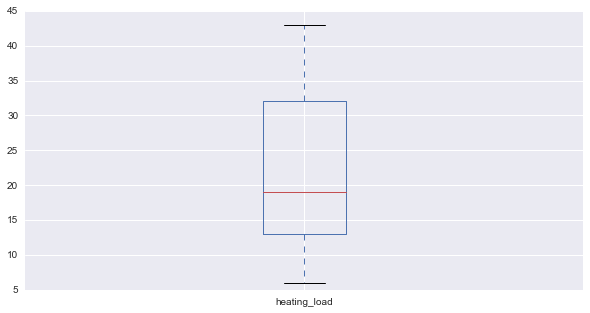

In [5]:
en.heating_load.plot(kind='box', figsize=(10,5))

## Exercise !

Say we wanted to predict whether or not a building has a high heating load (>= 40). We would then create a new feature where heating_load is greater than or equal to 40:

*_You can create new feautres by referencing a new key in your dataframe for this exercize._


In [6]:
## This is important to reference later so we can use it as a threshold
# Solution here:

en['high_heat'] = en.heating_load >= 40

How does our data set look now in terms of this target label:

In [7]:
print "Mean value: {:.03f}".format(en['high_heat'].mean())
print "\nValue Counts: "

en.high_heat.value_counts()

Mean value: 0.060

Value Counts: 


False    722
True      46
Name: high_heat, dtype: int64

Let's classify! We'll use K nearest neighbors to see how well we do :D

## Exercise !

Build a KNN model with 5 neighbors, then check out the cross validation score.

In [8]:
# Use this data
data = en.iloc[:,:-2]
labels = en['high_heat']

model_knn = KNeighborsClassifier(5)
scores = cross_val_score(model_knn, data, labels, cv=5)
print "Crossvalidated KNN Model, Simple Accuracy: {:.03f}".format(np.mean(scores))

Crossvalidated KNN Model, Simple Accuracy: 0.978


Hooray! 97% is great right? Well, the leading question might be giving the game away here: 97% is a good overall score but if our goal is to properly predict a High Heating Load building, then we'll need a bit more info. In classification, a confusion matrix is a way of showing finer detail of our classifier performance.

To get a confusion matrix, we need to look at only a single train/test split. So lets do that: 

In [9]:
data = en.iloc[:,:-3]
labels = en['high_heat']

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=1)  

# Build the classifier and get the predictions
model_knn = KNeighborsClassifier(5)

model_knn.fit(X_train, Y_train)  
predictions = model_knn.predict(X_test)

### Confusion Matrix
The confusion matrix shows the predicted values along the columns and the actual values along the rows. 


Sklearn defaults to alphabetical order so the Columns would read `False, True` as would our rows. These yield our **False Positives** (here we have 1 data point where we said the data point was `True` and it was `False`) and our **False Negatives** (6 predicted `False` but actually `True`). Our **True Positives** = 9.
Illustrated more cleanly:

In [10]:
cm = confusion_matrix(Y_test,predictions)
print cm

[[141   4]
 [  2   7]]


In [11]:
#lets make that easier to read
cm_df = pd.DataFrame(cm, index=['Predicted Class 0', 'Predicted Class 1'], 
                     columns=['Actual Class 0', 'Actual Class 1'])

cm_df

,Actual Class 0,Actual Class 1
Predicted Class 0,141,4
Predicted Class 1,2,7


## Exercise !

To get a sense about how different settings and models perform.

In [12]:
# How does our matrix change if we change the headload threashold to .2?
en['high_heat'] = en.heating_load >= 20

data = en.iloc[:,:-2]
labels = en['high_heat']

model_knn = KNeighborsClassifier(5)
scores = cross_val_score(model_knn, data, labels, cv=5)
print "Crossvalidated KNN Model, Simple Accuracy: {:.03f}".format(np.mean(scores))

Crossvalidated KNN Model, Simple Accuracy: 0.986


In [13]:
cm = confusion_matrix(Y_test,predictions)
print cm
cm_df = pd.DataFrame(cm, index=['Predicted Class 0', 'Predicted Class 1'], 
                     columns=['Actual Class 0', 'Actual Class 1'])

cm_df

# It doesn't change that much does it?  Because the parameters of the model may have more impact than changing the 
# threashold of our target.  Let's find out.

[[141   4]
 [  2   7]]


,Actual Class 0,Actual Class 1
Predicted Class 0,141,4
Predicted Class 1,2,7


In [14]:
# How does our matrix change if we change the number of neighbors on out of sample data?  We should test with cross / train split.
en['high_heat'] = en.heating_load >= 40

data = en.iloc[:,:-2]
labels = en['high_heat']

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=1)  

model_knn = KNeighborsClassifier(10) # See what happens when you run with 5, 10, 20, 30, 40 -- this has an impact on True Positives and False Negatives as you add more neighbors.
model_knn.fit(X_train, Y_train)  
predictions = model_knn.predict(X_test)

scores = cross_val_score(model_knn, data, labels, cv=5)
print "Crossvalidated KNN Model, Simple Accuracy: {:.03f}".format(np.mean(scores))

cm = confusion_matrix(Y_test,predictions)
cm_df = pd.DataFrame(cm, index=['Predicted Class 0', 'Predicted Class 1'], 
                     columns=['Actual Class 0', 'Actual Class 1'])

cm_df


Crossvalidated KNN Model, Simple Accuracy: 0.978


,Actual Class 0,Actual Class 1
Predicted Class 0,141,4
Predicted Class 1,0,9


In [15]:
# How does our matrix score change if we use a different classifier like logistic regression?

model_lr = LogisticRegression(C=1)

model_lr.fit(X_train, Y_train) # reusing from last cell
predictions = model_lr.predict(X_test)

cm = confusion_matrix(Y_test,predictions)
cm_df = pd.DataFrame(cm, index=['Predicted Class 0', 'Predicted Class 1'], 
                     columns=['Actual Class 0', 'Actual Class 1'])

cm_df

,Actual Class 0,Actual Class 1
Predicted Class 0,142,3
Predicted Class 1,0,9


How are these results? Are they good?  What could be the problem?  Let's make our evaluation easier to look at.

# ROC (Receiver Operator Characteristic) Plots
The ROC curve illustrates the performance of a binary classifier system as its discrimination threshold is varied. We use ROC to compare models using the Area Under Curve (AUC) statistic. Generally, 1 is a perfect model and < 0.5 is worse than guessing. Remember for logistic regression, our probability function looks like:

In [16]:
def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = auc(fpr, tpr)
    
    p = figure(title='Receiver Operating Characteristic')
    # Plot ROC curve
    p.line(x=fpr,y=tpr,legend='ROC curve (area = %0.3f)' % roc_auc)
    p.x_range=Range1d(0,1)
    p.y_range=Range1d(0,1)
    p.xaxis.axis_label='False Positive Rate or (1 - Specifity)'
    p.yaxis.axis_label='True Positive Rate or (Sensitivity)'
    p.legend.orientation = "bottom_right"
    show(p)
    
%matplotlib inline

In [17]:
# Let's reset our data
en = pd.read_csv('../data/ENB2012_data.csv',header=0)

# Set a target
en['high_heat'] = en.heating_load >= 40

# Set the labels for training
label = en['high_heat']

# remove extranious features
data = en.drop(['heating_load','cooling_load','high_heat'], axis=1)

# Split our data into train and test splits
train_feat, test_feat, train_target, test_target = train_test_split(data, label, train_size=0.3)

In [18]:
model_lr = LogisticRegression(C=1).fit(train_feat, train_target)
target_predicted_proba = model_lr.predict_proba(test_feat)

In [19]:
plot_roc_curve(test_target, target_predicted_proba)

/Users/samuelbolivar/anaconda/lib/python2.7/site-packages/bokeh/core/properties.py:714: BokehDeprecationWarning: bokeh.models.annotations.orientation was deprecated in Bokeh 0.11; please use Legend.location instead
  super(HasProps, self).__setattr__(name, value)


In [20]:
neg = en[en['high_heat'] == False]
pos = en[en['high_heat'] == True]

oversample_en = pd.concat([neg, pos.sample(700, replace = True)])
label = oversample_en['high_heat']
data = oversample_en.drop(['heating_load','cooling_load','high_heat'],axis=1)
train_feat, test_feat, train_target, test_target = train_test_split(data,label, train_size=0.3)

In [21]:
model_lr = LogisticRegression(C=.1).fit(train_feat, train_target)
target_predicted_proba = model_lr.predict_proba(test_feat)

plot_roc_curve(test_target, target_predicted_proba)

/Users/samuelbolivar/anaconda/lib/python2.7/site-packages/bokeh/core/properties.py:714: BokehDeprecationWarning: bokeh.models.annotations.orientation was deprecated in Bokeh 0.11; please use Legend.location instead
  super(HasProps, self).__setattr__(name, value)


## Unbalanced Classes Setup

See above for external package setup.

Back to our confusion matrix.  Let's refresh our data first.

In [22]:
en = pd.read_csv('../data/ENB2012_data.csv',header=0)
en.info()

#Samuel
en = pd.read_csv('../data/ENB2012_data.csv',header=0)
en['high_heat'] = en.heating_load >= 40
label = en['high_heat']
data = en.drop(['heating_load','cooling_load','high_heat'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
rel_compact          768 non-null float64
surface              768 non-null float64
wall                 768 non-null float64
roof                 768 non-null float64
height               768 non-null float64
orientation          768 non-null int64
glazing_area         768 non-null float64
glazing_area_dist    768 non-null int64
heating_load         768 non-null float64
cooling_load         768 non-null float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


Remember our results?  Could be better right?

### Strategy 1: Sample from the overloaded class
If we put the two classes on the same order of magnitude we can hope that our Model de-emphasizes its accuracy on the Falses with hopes of improving our scores on predicting the underrepresented class. One approach is to use less data from our overloaded class.

In [23]:
# 'Random under-sampling'
x = data.values
y = labels.values

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=1)  

In [24]:
#Note we are keeping our test set out of this undersampling routing

#Modified
from imblearn.under_sampling import RandomUnderSampler
US = RandomUnderSampler()
usx, usy = US.fit_sample(X_train,Y_train)

#Original
#US = UnderSampler(verbose=True)
#usx, usy = US.fit_transform(X_train,Y_train)

In [25]:
### Lets plug this undersampled data back into a dataframe to see how it looks now. 
us_df = pd.DataFrame(usx, columns=data.columns)
us_df['labels'] = usy
us_df.describe().T

,count,mean,std,min,25%,50%,75%,max
rel_compact,74.0,0.775135,0.073750,0.62,0.76,0.79,0.79,0.98
surface,74.0,655.540541,62.008603,514.50,637.00,637.00,661.50,808.50
wall,74.0,344.655405,49.886579,245.00,318.50,343.00,367.50,416.50
roof,74.0,155.442568,37.602953,110.25,122.50,147.00,147.00,220.50
height,74.0,6.195946,1.482356,3.50,7.00,7.00,7.00,7.00
orientation,74.0,3.391892,1.120391,2.00,2.00,3.00,4.00,5.00
glazing_area,74.0,0.300000,0.125785,0.00,0.25,0.40,0.40,0.40
glazing_area_dist,74.0,2.986486,1.539376,0.00,2.00,3.00,4.00,5.00


### Exercise

- Using our new UnderSampled Data, test the performance of Logistic Regression, Naive Bayes, and KNN on this data. 

In [26]:
from sklearn.naive_bayes import GaussianNB

#All three at once!
model_names = ['Logistic Regression', 'KNN', 'Naive Bayes']
models = [LogisticRegression(C=1), KNeighborsClassifier(5), GaussianNB()]
i = 0
for model in models:
    
    model.fit(usx, usy)  
    predictions = model.predict(X_test)

    cm = confusion_matrix(Y_test,predictions)

    #lets make that easier to read
    cm_df = pd.DataFrame(cm, columns=['Predicted Class 0', 'Predicted Class 1'], 
                             index=['Actual Class 0', 'Actual Class 1'])

    print "Results of {}: ".format(model_names[i])
    print cm_df,'\n'
    print "Precision:",float(cm[1,1])/(cm[0,1]+cm[1,1])
    print "Recall:",float(cm[1,1])/(cm[1,0]+cm[1,1]),'\n'
    print "============================================"
    i +=1

Results of Logistic Regression: 
                Predicted Class 0  Predicted Class 1
Actual Class 0                 93                 52
Actual Class 1                  1                  8 

Precision: 0.133333333333
Recall: 0.888888888889 

Results of KNN: 
                Predicted Class 0  Predicted Class 1
Actual Class 0                126                 19
Actual Class 1                  0                  9 

Precision: 0.321428571429
Recall: 1.0 

Results of Naive Bayes: 
                Predicted Class 0  Predicted Class 1
Actual Class 0                117                 28
Actual Class 1                  0                  9 

Precision: 0.243243243243
Recall: 1.0 



Did this get better?  What happened?

Well, yes and no. We traded off between precision, correctly classifying as over 40, and recall, classifying more of the positives as positives. In practice, a mixture of both Over & Under sampling is used. 

### Strategy 2: Oversample the underrepresented class

To oversample, we will use all of our negative values and sample from our positive values a number that's more reasonable. Note the `replace = True` argument: we need to sample **with replacement** meaning after we sample a value, we replace the value we sampled in our original set, so it remains un changed. Before, sampling was done without replacement, guaranteeing unique values.

Sampling with replacement is not the same as SMOTE, which creates synthetic data. For more information on SMOTE, check out the original paper here: https://www.jair.org/media/953/live-953-2037-jair.pdf

In [27]:
# 'Random over-sampling'
x = data.values
y = labels.values

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=1)  

In [28]:
from imblearn.over_sampling import SMOTE

#Samuel
verbose = True
ratio = 1.0

OS = SMOTE(ratio=ratio, verbose=verbose)
osx, osy = OS.fit_sample(X_train, Y_train)

#Original
#verbose = True
#ratio = 10.0

#OS = SMOTE(ratio=ratio, verbose=verbose)
#osx, osy = OS.fit_transform(X_train, Y_train)

In [29]:
os_df = pd.DataFrame(osx, columns=data.columns)
os_df['labels'] = osy
os_df.describe().T

,count,mean,std,min,25%,50%,75%,max
rel_compact,1154.0,0.770520,0.079076,0.62,0.740000,0.790000,0.790000,0.98
surface,1154.0,660.332322,66.725969,514.50,637.000000,637.000000,686.000000,808.50
wall,1154.0,342.002166,47.506198,245.00,318.500000,343.000000,367.500000,416.50
roof,1154.0,159.165078,39.354455,110.25,122.500000,147.000000,220.500000,220.50
height,1154.0,6.041594,1.561407,3.50,3.500000,7.000000,7.000000,7.00
orientation,1154.0,3.552941,1.056043,2.00,2.886220,3.825558,4.419216,5.00
glazing_area,1154.0,0.292232,0.122328,0.00,0.250000,0.330265,0.400000,0.40
glazing_area_dist,1154.0,2.829478,1.473845,0.00,1.707369,3.000000,4.000000,5.00


### Exercise

- Using our new OverSampled Data, test the performance of Logistic Regression, Naive Bayes, and KNN on this data.  

In [30]:
#All three at once!
model_names = ['Logistic Regression', 'KNN', 'Naive Bayes']
models = [LogisticRegression(C=1), KNeighborsClassifier(5), GaussianNB()]
i = 0
for model in models:
    print model
    model.fit(osx, osy)  
    predictions = model.predict(X_test)

    cm = confusion_matrix(Y_test,predictions)

    #lets make that easier to read
    cm_df = pd.DataFrame(cm, columns=['Predicted Class 0', 'Predicted Class 1'], 
                             index=['Actual Class 0', 'Actual Class 1'])

    print "Results of {}: ".format(model_names[i])
    print cm_df,'\n'
    print "Precision:",float(cm[1,1])/(cm[0,1]+cm[1,1])
    print "Recall:",float(cm[1,1])/(cm[1,0]+cm[1,1]),'\n'
    print "============================================"
    i +=1

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Results of Logistic Regression: 
                Predicted Class 0  Predicted Class 1
Actual Class 0                110                 35
Actual Class 1                  0                  9 

Precision: 0.204545454545
Recall: 1.0 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Results of KNN: 
                Predicted Class 0  Predicted Class 1
Actual Class 0                128                 17
Actual Class 1                  0                  9 

Precision: 0.346153846154
Recall: 1.0 

GaussianNB()
Results of Naive Bayes: 
                Predicted Class 0  Predicted Class 1
Actual Class 0                

But the model got worse or better? (worse)
Well, yes and no. We traded off between precision, correctly classifying as over 40, and recall, classifying more of the positives as positives. In practice, a mixture of both Over & Under sampling is used. 

### Exercise
- Repeat our process for a high cooling load
- Reinstantiate your data and then set the high cooling load at an appropriate value (I'll get you started).

In [31]:
en = pd.read_csv('../data/ENB2012_data.csv',header=0)
# Set a target
en['high_cool'] = en.cooling_load >= 40
en.high_cool.value_counts()

False    721
True      47
Name: high_cool, dtype: int64

In [32]:
# Set the labels for training
label = en['high_cool']

# remove extranious features
data = en.drop(['heating_load','cooling_load','high_cool'], axis=1)
print data.describe().T

X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.2, random_state=1) 

#Fit a logistic regression without using over or undersampling:
model_lr_exercise_a = LogisticRegression(C=1)

scores_exercise_a = cross_val_score(model_lr_exercise_a, data, label, cv=5)

model_lr_exercise_a.fit(X_train, Y_train)
predictions_exercise_a = model_lr_exercise_a.predict(X_test)

cm_exercise_a = confusion_matrix(Y_test,predictions_exercise_a)
cm_df_exercise_a = pd.DataFrame(cm_exercise_a, index=['Predicted Class 0', 'Predicted Class 1'], 
                                columns=['Actual Class 0', 'Actual Class 1'])

print "Results of Logistic Regression:"
print cm_df_exercise_a,'\n'
#print "Precision:",float(cm_exercise_a[1,1])/(cm_exercise_a[0,1]+cm_exercise_a[1,1])
print "Recall:",float(cm_exercise_a[1,1])/(cm_exercise_a[1,0]+cm_exercise_a[1,1]),'\n'
print "Accuracy Score: {:.03f}".format(np.mean(scores_exercise_a))

                   count        mean        std     min       25%     50%  \
rel_compact        768.0    0.764167   0.105777    0.62    0.6825    0.75   
surface            768.0  671.708333  88.086116  514.50  606.3750  673.75   
wall               768.0  318.500000  43.626481  245.00  294.0000  318.50   
roof               768.0  176.604167  45.165950  110.25  140.8750  183.75   
height             768.0    5.250000   1.751140    3.50    3.5000    5.25   
orientation        768.0    3.500000   1.118763    2.00    2.7500    3.50   
glazing_area       768.0    0.234375   0.133221    0.00    0.1000    0.25   
glazing_area_dist  768.0    2.812500   1.550960    0.00    1.7500    3.00   

                       75%     max  
rel_compact          0.830    0.98  
surface            741.125  808.50  
wall               343.000  416.50  
roof               220.500  220.50  
height               7.000    7.00  
orientation          4.250    5.00  
glazing_area         0.400    0.40  
glazing_ar

In [33]:
#Fit a Logistic Regression using Undersampling:

US_exercise = RandomUnderSampler()
usx_exercise, usy_exercise = US_exercise.fit_sample(X_train,Y_train)

### Lets plug this undersampled data back into a dataframe to see how it looks now. 
us_df_exercise = pd.DataFrame(usx_exercise, columns=data.columns)
us_df_exercise['labels'] = usy_exercise
print '\n'
print "Data Frame Description:"
print us_df_exercise.describe().T
print '\n'
print "Labels Count:"
print us_df_exercise['labels'].value_counts()

model_lr_exercise_b = LogisticRegression(C=1)

scores_exercise_b = cross_val_score(model_lr_exercise_b, usx_exercise, usy_exercise, cv=5)
    
model_lr_exercise_b.fit(usx_exercise, usy_exercise)
predictions_exercise_b = model_lr_exercise_b.predict(X_test)

cm_exercise_b = confusion_matrix(Y_test,predictions_exercise_b)
cm_df_exercise_b = pd.DataFrame(cm_exercise_b, index=['Predicted Class 0', 'Predicted Class 1'], 
                                columns=['Actual Class 0', 'Actual Class 1'])

print '\n'
print "Results of Logistic Regression:"
print cm_df_exercise_b,'\n'
print '\n'
print "Precision:",float(cm_exercise_b[1,1])/(cm_exercise_b[0,1]+cm_exercise_b[1,1])
print "Recall:",float(cm_exercise_b[1,1])/(cm_exercise_b[1,0]+cm_exercise_b[1,1]),'\n'
print "Accuracy Score: {:.03f}".format(np.mean(scores_exercise_b))




Data Frame Description:
                   count        mean        std     min     25%     50%  \
rel_compact         72.0    0.765000   0.080928    0.62    0.69    0.79   
surface             72.0  665.583333  70.745328  514.50  637.00  637.00   
wall                72.0  341.979167  39.959878  269.50  318.50  343.00   
roof                72.0  161.802083  39.330129  110.25  122.50  147.00   
height              72.0    5.979167   1.602018    3.50    3.50    7.00   
orientation         72.0    3.666667   1.100576    2.00    3.00    4.00   
glazing_area        72.0    0.259722   0.134698    0.00    0.10    0.25   
glazing_area_dist   72.0    2.888889   1.458878    0.00    2.00    3.00   

                      75%     max  
rel_compact          0.79    0.98  
surface            735.00  808.50  
wall               343.00  416.50  
roof               220.50  220.50  
height               7.00    7.00  
orientation          5.00    5.00  
glazing_area         0.40    0.40  
glazing_ar

In [34]:
#Fit a Logistic Regression using Oversampling:

verbose = True
ratio = 1.0

OS_exercise = SMOTE(ratio=ratio, verbose=verbose)
osx_exercise, osy_exercise = OS_exercise.fit_sample(X_train, Y_train)

os_df_exercise = pd.DataFrame(osx_exercise, columns=data.columns)
os_df_exercise['labels'] = osy_exercise
print '\n'
print "Data Frame Description:"
print os_df_exercise.describe().T
print '\n'
print "Labels Count:"
print os_df_exercise['labels'].value_counts()

model_lr_exercise_c = LogisticRegression(C=1)

scores_exercise_c = cross_val_score(model_lr_exercise_c, osx_exercise, osy_exercise, cv=5)
    
model_lr_exercise_c.fit(osx_exercise, osy_exercise)
predictions_exercise_c = model_lr_exercise_c.predict(X_test)

cm_exercise_c = confusion_matrix(Y_test,predictions_exercise_c)
cm_df_exercise_c = pd.DataFrame(cm_exercise_c, index=['Predicted Class 0', 'Predicted Class 1'], 
                                columns=['Actual Class 0', 'Actual Class 1'])

print '\n'
print "Results of Logistic Regression:"
print cm_df_exercise_c,'\n'
print '\n'
print "Precision:",float(cm_exercise_c[1,1])/(cm_exercise_c[0,1]+cm_exercise_c[1,1])
print "Recall:",float(cm_exercise_c[1,1])/(cm_exercise_c[1,0]+cm_exercise_c[1,1]),'\n'
print "Accuracy Score: {:.03f}".format(np.mean(scores_exercise_c))



Data Frame Description:
                    count        mean        std     min         25%     50%  \
rel_compact        1156.0    0.773560   0.080752    0.62    0.740000    0.79   
surface            1156.0  658.167491  67.903419  514.50  637.000000  637.00   
wall               1156.0  339.600236  45.952508  245.00  318.500000  343.00   
roof               1156.0  159.283627  39.203789  110.25  122.500000  147.00   
height             1156.0    6.043253   1.560563    3.50    3.500000    7.00   
orientation        1156.0    3.607811   1.092767    2.00    3.000000    4.00   
glazing_area       1156.0    0.262243   0.127122    0.00    0.102616    0.25   
glazing_area_dist  1156.0    2.987351   1.456904    0.00    2.000000    3.00   

                         75%     max  
rel_compact          0.79000    0.98  
surface            686.00000  808.50  
wall               343.00000  416.50  
roof               220.50000  220.50  
height               7.00000    7.00  
orientation        